(Colab Notebook)[https://colab.research.google.com/drive/1efK6ZUvx1opdjFOz6PTl6R-FqiiEIIHR?usp=sharing]
# Brain Tumor MRI Classification using Deep Learning (Xception)

**Team Name:** Deadlock  
**Competition:** BioFusion Hackathon – IEEE EMBS  
**Task:** Multiclass Brain Tumor Classification from MRI  
**Model:** Xception (Pretrained on ImageNet)

---



## 1. Problem Definition

### Clinical Relevance
Brain tumors are life-threatening neurological conditions requiring early and accurate diagnosis.
MRI is the primary imaging modality used in clinical practice, but manual interpretation is time-
consuming and subject to inter-observer variability.

### Objective
To classify brain MRI images into four clinically relevant categories:
- Glioma
- Meningioma
- Pituitary Tumor
- No Tumor

This system acts as a **clinical decision support tool**, not a replacement for clinicians.



## 2. Dataset Documentation

### Dataset Source
Brain Tumor MRI Dataset (Open-source – Kaggle)  
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

### Dataset Size
- Training set: 5,714 images
- Testing set: 1,311 images

### Class Labels
Glioma, Meningioma, Pituitary, No Tumor


In [ ]:

# Import Libraries
import os # For operating system interactions
import numpy as np # For numerical operations
import pandas as pd # For data manipulation
import matplotlib.pyplot as plt # For plotting graphs
import seaborn as sns # For advanced data visualization
from PIL import Image # For image processing

from sklearn.model_selection import train_test_split # For splitting datasets
from sklearn.metrics import classification_report, confusion_matrix # For model evaluation

import tensorflow as tf # For building and training neural networks
from tensorflow.keras.models import Sequential # For creating sequential models
from tensorflow.keras.layers import Dense, Dropout, Flatten # For building neural network layers
from tensorflow.keras.optimizers import Adamax # For optimization algorithms
from tensorflow.keras.metrics import Precision, Recall # For performance metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For image data augmentation

from google.colab import drive # For Google Drive integration
drive.mount('/content/drive')


Mounted at /content/drive



## 3. Data Loading and Understanding


In [ ]:

def create_image_dataframe(base_path): # Function to create a DataFrame from image directories
    data = []
    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                data.append({
                    "Image_Path": os.path.join(label_path, image),
                    "Image_Class": label
                })
    return pd.DataFrame(data)

train_df = create_image_dataframe('/content/drive/MyDrive/BioFusion/data/Training') # Create DataFrame for training images
test_df  = create_image_dataframe('/content/drive/MyDrive/BioFusion/data/Testing') # Create DataFrame for testing images

train_df.shape, test_df.shape


((5714, 2), (1311, 2))

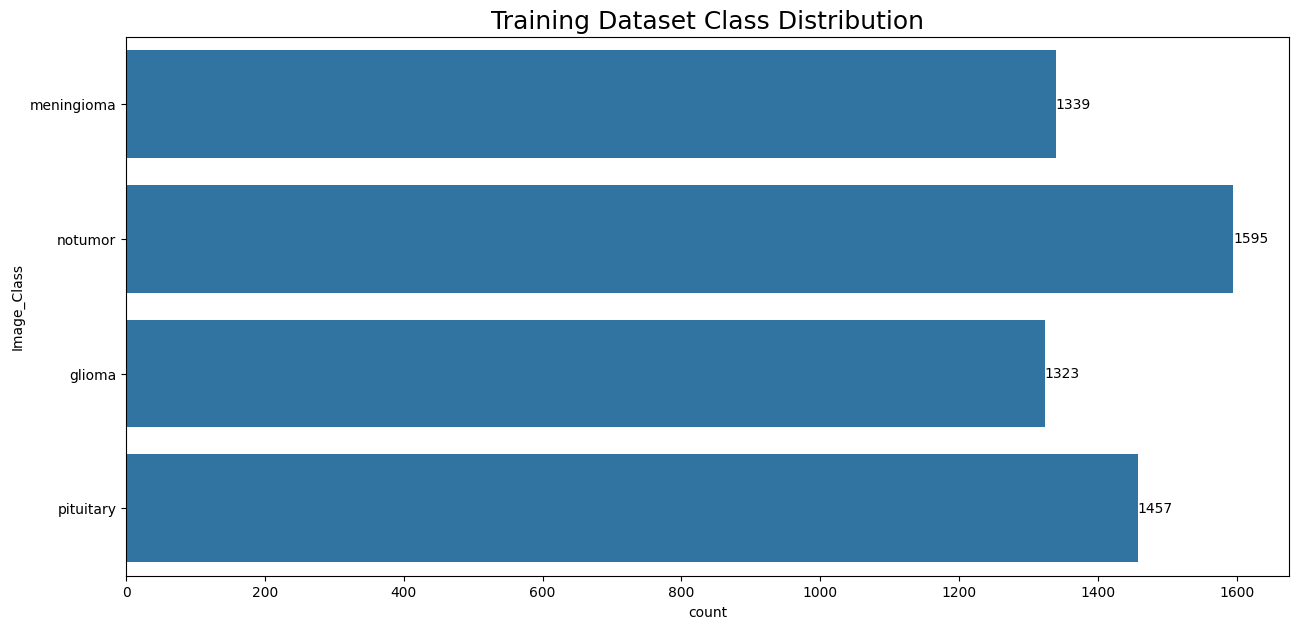

In [ ]:

plt.figure(figsize=(15,7))
ax = sns.countplot(y=train_df['Image_Class'])
plt.title('Training Dataset Class Distribution', fontsize=18)
ax.bar_label(ax.containers[0])
plt.show()



## 4. Data Preprocessing


In [ ]:

valid_df, ts_df = train_test_split(
    test_df,
    train_size=0.5,
    stratify=test_df['Image_Class'],
    random_state=20
)

batch_size = 32
img_size = (299, 299)

train_gen = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2)
)

test_gen = ImageDataGenerator(rescale=1/255)

tr_gen = train_gen.flow_from_dataframe(
    train_df,
    x_col='Image_Path',
    y_col='Image_Class',
    target_size=img_size,
    batch_size=batch_size
)

valid_gen = test_gen.flow_from_dataframe(
    valid_df,
    x_col='Image_Path',
    y_col='Image_Class',
    target_size=img_size,
    batch_size=batch_size
)

ts_gen = test_gen.flow_from_dataframe(
    ts_df,
    x_col='Image_Path',
    y_col='Image_Class',
    target_size=img_size,
    batch_size=16,
    shuffle=False
)


Found 5714 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.



## 5. Model Initialization & Pretrained Disclosure

### Pretrained Model Used
- Model Name: **Xception**
- Source: TensorFlow / Keras
- Pretraining Dataset: ImageNet
- Weight Usage: **Pretrained weights used**

### Architecture Strategy
The pretrained Xception backbone is used as a feature extractor, followed by
custom fully connected layers for task-specific adaptation.


In [ ]:

img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
)

base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)


## 6. Model Training


In [ ]:

history = model.fit(
    tr_gen,
    epochs=10,
    validation_data=valid_gen,
    shuffle=False
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1939s 11s/step - accuracy: 0.6517 - loss: 0.9387 - precision: 0.6899 - recall: 0.6036 - val_accuracy: 0.8168 - val_loss: 0.4554 - val_precision: 0.8832 - val_recall: 0.7847
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 292ms/step - accuracy: 0.8312 - loss: 0.4489 - precision: 0.8540 - recall: 0.8036 - val_accuracy: 0.8321 - val_loss: 0.4016 - val_precision: 0.8731 - val_recall: 0.8092
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 301ms/step - accuracy: 0.8503 - loss: 0.3916 - precision: 0.8714 - recall: 0.8358 - val_accuracy: 0.8718 - val_loss: 0.3283 - val_precision: 0.8966 - val_recall: 0.8473
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 301ms/step - accuracy: 0.8753 - loss: 0.3351 - precision: 0.8895 - recall: 0.8576 - val_accuracy: 0.8870 - val_loss: 0.2961 - val_precision: 0.8995 - val_recall: 0.8748
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 301ms/step - accuracy: 0.8863 - loss: 0.3122 - precision: 0.8989 - recall: 0.8705 - val_accuracy: 0.8763


## 7. Training Logs and Curves


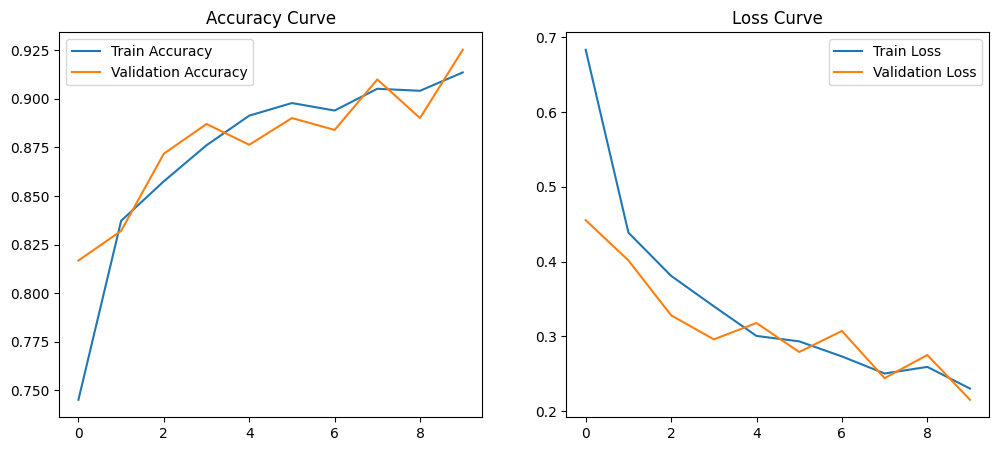

In [ ]:

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.show()



## 8. Model Evaluation


In [ ]:

train_score = model.evaluate(tr_gen, verbose=0)
valid_score = model.evaluate(valid_gen, verbose=0)
test_score  = model.evaluate(ts_gen, verbose=0)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


Train Accuracy: 95.20%
Validation Accuracy: 92.52%
Test Accuracy: 90.85%


41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step


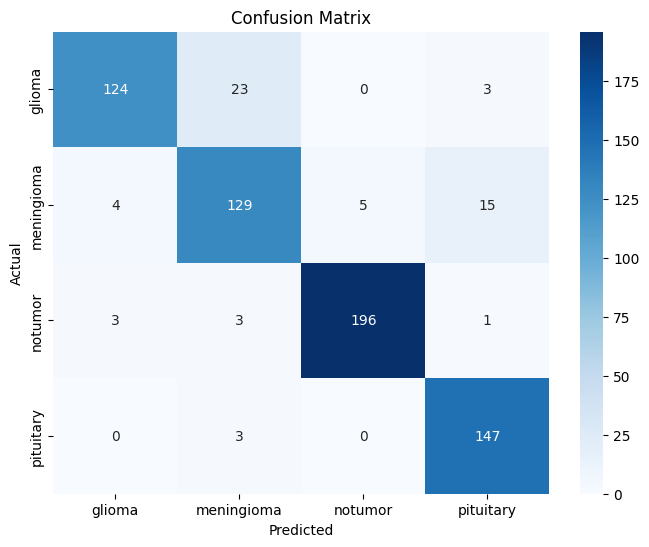

In [ ]:

preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(tr_gen.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

print(classification_report(ts_gen.classes, y_pred, target_names=labels))


              precision    recall  f1-score   support

      glioma       0.95      0.83      0.88       150
  meningioma       0.82      0.84      0.83       153
     notumor       0.98      0.97      0.97       203
   pituitary       0.89      0.98      0.93       150

    accuracy                           0.91       656
   macro avg       0.91      0.90      0.90       656
weighted avg       0.91      0.91      0.91       656




## 9. Error Analysis & Limitations

- Minor confusion between Glioma and Meningioma due to similar MRI appearance
- Domain mismatch between ImageNet and MRI images
- Dataset limited to 2D slices



## 10. Reproducibility

- Fixed random state during dataset splitting
- Explicit data paths
- Fully runnable on Google Colab


In [ ]:

# Save trained model
model.save('Deadlock_Xception_BioFusion_Model.h5')
